# ML-based Prediction of Cyber Attacks using MQTT Dataset

### Libraries and Initialization

In [1]:
import os
import sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable


import findspark
findspark.init()
findspark.find()

import pyspark
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml import Pipeline,Transformer
from pyspark.ml.feature import Imputer,StandardScaler,StringIndexer,OneHotEncoder, VectorAssembler

from pyspark.sql.functions import *
from pyspark.sql.types import *

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

import numpy as np
from matplotlib import pyplot as plt


spark = SparkSession.builder \
    .master("local[*]") \
    .appName("GenericAppName") \
    .getOrCreate()

sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

spark

C:\Spark\spark-3.2.2-bin-hadoop2.7\python\pyspark\sql\context.py:77: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


# Task I

#### Original Dataset

In [3]:
train_path = "./mqtt_data/train70_augmented.csv"
test_path = "./mqtt_data/test30_augmented.csv"

# for GCP
#train_path = "gs://dataproc-staging-us-east5-759808834804-ifoixyen/mqtt_data/train70_augmented.csv"
#test_path = "gs://dataproc-staging-us-east5-759808834804-ifoixyen/mqtt_data/test30_augmented.csv"

# Adding binary Train_or_Test column
#Train == 0 , Test == 1
df0 = spark.read.csv(train_path, header='true').withColumn("Train_or_Test", lit(0))
df1 = spark.read.csv(test_path, header='true').withColumn("Train_or_Test", lit(1))

# Merged dataset with 20,000,000 rows
DF = df0.union(df1)
DF.count()

20000000

In [11]:
DF.printSchema()

root
 |-- tcp.flags: string (nullable = true)
 |-- tcp.time_delta: string (nullable = true)
 |-- tcp.len: string (nullable = true)
 |-- mqtt.conack.flags: string (nullable = true)
 |-- mqtt.conack.flags.reserved: string (nullable = true)
 |-- mqtt.conack.flags.sp: string (nullable = true)
 |-- mqtt.conack.val: string (nullable = true)
 |-- mqtt.conflag.cleansess: string (nullable = true)
 |-- mqtt.conflag.passwd: string (nullable = true)
 |-- mqtt.conflag.qos: string (nullable = true)
 |-- mqtt.conflag.reserved: string (nullable = true)
 |-- mqtt.conflag.retain: string (nullable = true)
 |-- mqtt.conflag.uname: string (nullable = true)
 |-- mqtt.conflag.willflag: string (nullable = true)
 |-- mqtt.conflags: string (nullable = true)
 |-- mqtt.dupflag: string (nullable = true)
 |-- mqtt.hdrflags: string (nullable = true)
 |-- mqtt.kalive: string (nullable = true)
 |-- mqtt.len: string (nullable = true)
 |-- mqtt.msg: string (nullable = true)
 |-- mqtt.msgid: string (nullable = true)
 |--

In [4]:
train_length = DF.where(DF["Train_or_Test"]==0).count()
test_length = DF.where(DF["Train_or_Test"]==1).count()

print ("Length of the original data sets")
print (f"Train set length: {train_length}")
print (f"Test set length: {test_length}")

Length of the original data sets
Train set length: 14000000
Test set length: 6000000


#### Reduced Dataset

    Reduced subsets were created from the original dataset (5% random sampling). 

    Only the reduced dataset (~1 million rows) was ingested to Postgres since reading the original dataset (20 million rows) from
    the Postgres DB prompted out-of-memory error. The sampling rate of 5% was chosen so that the model training codes are executed 
    within tolerable runtimes, without any out-of-memory error.



In [5]:
# 5% of train and test set to prevent OOM
reduced_train = df0.sample(0.05, seed=100)
reduced_test = df1.sample(0.05, seed=100)
reduced_df = reduced_train.union(reduced_test)

reduced_train_len = reduced_train.where(reduced_train["Train_or_Test"]==0).count()
reduced_test_len = reduced_test.where(reduced_test["Train_or_Test"]==1).count()

print ("Length of the reduced data sets")
print (f"Train set length: {reduced_train_len}")
print (f"Test set length: {reduced_test_len}")
print (f"Total: {reduced_df.count()}")

Length of the reduced data sets
Train set length: 699669
Test set length: 300094
Total: 999763


#### Postgres

In [7]:
df = reduced_df

db_properties={}
db_properties['url']= "jdbc:postgresql://localhost:5432/postgres"
db_properties['table']= "reduced_mqtt"
db_properties['username']="postgres"
db_properties['password']="$M8f5w2~"
db_properties['driver']="org.postgresql.Driver"

def ingest_df (df):
    # Ingestion to postgres
    df.write.format("jdbc")\
        .mode("overwrite")\
        .option("url", db_properties['url'])\
        .option("dbtable", db_properties['table'])\
        .option("user", db_properties['username'])\
        .option("password", db_properties['password'])\
        .option("Driver", db_properties['driver'])\
        .save()
    
    print ("--- DataFrame ingested to Postgres.")
    
# Ingestion
ingest_df (reduced_df)

In [8]:
# Read from postgres
df_read = sqlContext.read.format("jdbc")\
    .option("url", db_properties['url'])\
    .option("dbtable", db_properties['table'])\
    .option("user", db_properties['username'])\
    .option("password", db_properties['password'])\
    .option("Driver", db_properties['driver'])\
    .load()

# Task II

In [10]:
# renaming df for convenience
df = df_read

#### Renaming columns

The original column names contain periods ($"."$) and this often leads to error and confusion because period is generally used to access modules in Python. Thus, all periods in the column names were replaced with underscores ($"\_"$).

In [12]:
column_names = df.columns

new_column_names = []
for column in column_names:
    underscore = column.replace (".", "_")
    new_column_names.append (underscore)
    
# Column Rename
for i,j in zip(column_names, new_column_names):
    df = df.withColumnRenamed(i, j)
    
df.printSchema()

root
 |-- tcp_flags: string (nullable = true)
 |-- tcp_time_delta: string (nullable = true)
 |-- tcp_len: string (nullable = true)
 |-- mqtt_conack_flags: string (nullable = true)
 |-- mqtt_conack_flags_reserved: string (nullable = true)
 |-- mqtt_conack_flags_sp: string (nullable = true)
 |-- mqtt_conack_val: string (nullable = true)
 |-- mqtt_conflag_cleansess: string (nullable = true)
 |-- mqtt_conflag_passwd: string (nullable = true)
 |-- mqtt_conflag_qos: string (nullable = true)
 |-- mqtt_conflag_reserved: string (nullable = true)
 |-- mqtt_conflag_retain: string (nullable = true)
 |-- mqtt_conflag_uname: string (nullable = true)
 |-- mqtt_conflag_willflag: string (nullable = true)
 |-- mqtt_conflags: string (nullable = true)
 |-- mqtt_dupflag: string (nullable = true)
 |-- mqtt_hdrflags: string (nullable = true)
 |-- mqtt_kalive: string (nullable = true)
 |-- mqtt_len: string (nullable = true)
 |-- mqtt_msg: string (nullable = true)
 |-- mqtt_msgid: string (nullable = true)
 |--

#### Average MQTT length in trainset

In [14]:
# Train/Test split
df0 = df.where (df["Train_or_Test"]==0)
df1 = df.where (df["Train_or_Test"]==1)


def avg_mqtt_len (DataFrame, return_df = True):
    """Input is a MQTT dataset in a Spark dataframe with renamed columns.
    Returns an average of MQTT message length (float) for the input dataframe."""
    
    avg_mqtt_df = DataFrame.groupBy("Train_or_Test") \
                            .agg(avg("mqtt_len").alias("avg_mqtt_len")) \
    
    avglen = avg_mqtt_df.select ("avg_mqtt_len").collect()[0][0]
    
    if return_df:
        return float (avglen), avg_mqtt_df
    else:
        return float (avglen)


# using the function on trainset
avg_mqtt0, avg_mqtt0_df = avg_mqtt_len(df0)
print (f"Avg MQTT length for the trainset: {avg_mqtt0:1.1f}")
avg_mqtt0_df.show ()

Avg MQTT length for the trainset: 12.3
+-------------+-----------------+
|Train_or_Test|     avg_mqtt_len|
+-------------+-----------------+
|            0|12.32957584229114|
+-------------+-----------------+



#### TCP length for each target

In [16]:
def avg_tcp_len (DataFrame, return_df = True):
    avg_tcp_df = DataFrame.groupBy("target").agg(avg("tcp_len").alias("avg_tcp_len"))
    
    avg_tcp_list = [avg_tcp_df.select ("avg_tcp_len").collect()[i][0] for i in range(avg_tcp_df.count())]
    
    if return_df:
        return avg_tcp_list, avg_tcp_df
    else:
        return avg_tcp_list

# on the train dataset
avg_tcp, avg_tcp_df = avg_tcp_len(df0)

# print results
print ("- Average TCP Length for each target")
for i in range (len(avg_tcp)):
    name = avg_tcp_df.select("target").collect()[i][0]
    print (f"{name.upper()}: {avg_tcp[i]:1.1f}")

avg_tcp_df.show ()

- Average TCP Length for each target
SLOWITE: 3.7
BRUTEFORCE: 3.3
FLOOD: 13591.1
MALFORMED: 21.3
DOS: 313.5
LEGITIMATE: 7.8
+----------+------------------+
|    target|       avg_tcp_len|
+----------+------------------+
|   slowite| 3.741847864934025|
|bruteforce|3.2720145956270135|
|     flood|13591.103289539522|
| malformed|  21.3200984696889|
|       dos| 313.5163415616549|
|legitimate| 7.777778411553994|
+----------+------------------+



**Most frequent X** TCP flags

In [17]:
def most_freq (DataFrame, X):
    count_list=[]
    
    tcp_flags = DataFrame.select('tcp_flags').distinct().collect()
    tcp_flags_val = [tcp_flags[i][0] for i in range(len(tcp_flags))]
    
    for i,value in enumerate (tcp_flags_val):
        count_list.append (DataFrame.select('tcp_flags').filter(f"tcp_flags=='{value}'").count())
        
    table = [(tcp_flags_val[i], count_list[i]) for i in range(len(count_list))]
    table.sort(key=lambda i: i[1], reverse=True) # sorting by counts
    
    df_tcp_flags = spark.createDataFrame(table[:X], ['tcp_flags','count'])
    return df_tcp_flags

In [18]:
# train dataset, 5 most frequent tcp_flags
df_freq = most_freq(df0, 5)
df_freq.show (truncate=False)

+----------+------+
|tcp_flags |count |
+----------+------+
|0x00000018|346487|
|0x00000010|272695|
|0x00000002|22156 |
|0x00000012|21920 |
|0x00000011|21573 |
+----------+------+



# Task III

### Data Preprocessing

#### Dropping columns
- columns with single distinct value are dropped
- generating lists of column names
- "mqtt_msg" dropped additionally due to large number of outliers
- "mqtt_protoname" dropped additionally since this feature is represented by another one "mqtt_proto_len"

In [19]:
cols_to_drop = []
binary_cols = []

print ("Distinct number of elements in each column:")
for i,column in enumerate(df.columns):
    distinct_count = df.select(column).distinct().count()
    if int(distinct_count) == 1:
        cols_to_drop.append (str(column))
    elif int(distinct_count) == 2:
        binary_cols.append (str(column))
    
    print (f"{df.columns[i]}: {distinct_count}")

Distinct number of elements in each column:
tcp_flags: 8
tcp_time_delta: 12370
tcp_len: 691
mqtt_conack_flags: 2
mqtt_conack_flags_reserved: 1
mqtt_conack_flags_sp: 1
mqtt_conack_val: 2
mqtt_conflag_cleansess: 2
mqtt_conflag_passwd: 2
mqtt_conflag_qos: 1
mqtt_conflag_reserved: 1
mqtt_conflag_retain: 1
mqtt_conflag_uname: 2
mqtt_conflag_willflag: 1
mqtt_conflags: 4
mqtt_dupflag: 2
mqtt_hdrflags: 14
mqtt_kalive: 7
mqtt_len: 91
mqtt_msg: 29037
mqtt_msgid: 9917
mqtt_msgtype: 11
mqtt_proto_len: 2
mqtt_protoname: 2
mqtt_qos: 2
mqtt_retain: 2
mqtt_sub_qos: 1
mqtt_suback_qos: 1
mqtt_ver: 2
mqtt_willmsg: 1
mqtt_willmsg_len: 1
mqtt_willtopic: 1
mqtt_willtopic_len: 1
target: 6
Train_or_Test: 2


In [20]:
cols_to_drop.append ("mqtt_msg")
cols_to_drop.append ("mqtt_protoname")

print ("cols_to_drop: \n", cols_to_drop, end='\n'*2)
print ("binary_cols: \n", binary_cols)

cols_to_drop: 
 ['mqtt_conack_flags_reserved', 'mqtt_conack_flags_sp', 'mqtt_conflag_qos', 'mqtt_conflag_reserved', 'mqtt_conflag_retain', 'mqtt_conflag_willflag', 'mqtt_sub_qos', 'mqtt_suback_qos', 'mqtt_willmsg', 'mqtt_willmsg_len', 'mqtt_willtopic', 'mqtt_willtopic_len', 'mqtt_msg', 'mqtt_protoname']

binary_cols: 
 ['mqtt_conack_flags', 'mqtt_conack_val', 'mqtt_conflag_cleansess', 'mqtt_conflag_passwd', 'mqtt_conflag_uname', 'mqtt_dupflag', 'mqtt_proto_len', 'mqtt_protoname', 'mqtt_qos', 'mqtt_retain', 'mqtt_ver', 'Train_or_Test']


In [22]:
# dataset for pipeline input
df_dropped = df.drop(*cols_to_drop)

df_dropped.printSchema()
df_dropped.show(1,vertical=True)

root
 |-- tcp_flags: string (nullable = true)
 |-- tcp_time_delta: string (nullable = true)
 |-- tcp_len: string (nullable = true)
 |-- mqtt_conack_flags: string (nullable = true)
 |-- mqtt_conack_val: string (nullable = true)
 |-- mqtt_conflag_cleansess: string (nullable = true)
 |-- mqtt_conflag_passwd: string (nullable = true)
 |-- mqtt_conflag_uname: string (nullable = true)
 |-- mqtt_conflags: string (nullable = true)
 |-- mqtt_dupflag: string (nullable = true)
 |-- mqtt_hdrflags: string (nullable = true)
 |-- mqtt_kalive: string (nullable = true)
 |-- mqtt_len: string (nullable = true)
 |-- mqtt_msgid: string (nullable = true)
 |-- mqtt_msgtype: string (nullable = true)
 |-- mqtt_proto_len: string (nullable = true)
 |-- mqtt_qos: string (nullable = true)
 |-- mqtt_retain: string (nullable = true)
 |-- mqtt_ver: string (nullable = true)
 |-- target: string (nullable = true)
 |-- Train_or_Test: integer (nullable = true)

-RECORD 0----------------------------
 tcp_flags             

#### Saving to Postgres

In [23]:
# ingesting "dropped_mqtt"
db_properties={}
db_properties['url']= "jdbc:postgresql://localhost:5432/postgres"
db_properties['table']= "dropped_mqtt"
db_properties['username']="postgres"
db_properties['password']="$M8f5w2~"
db_properties['driver']="org.postgresql.Driver"

ingest_df (df_dropped)

In [24]:
# Read from postgres
df_read = sqlContext.read.format("jdbc")\
    .option("url", db_properties['url'])\
    .option("dbtable", db_properties['table'])\
    .option("user", db_properties['username'])\
    .option("password", db_properties['password'])\
    .option("Driver", db_properties['driver'])\
    .load()

#### Preprocessing Pipeline

In [32]:
df = df_read

# Data before the pipeline (input)
df.show (1,vertical=True)

-RECORD 0----------------------------
 tcp_flags              | 0x00000018 
 tcp_time_delta         | 0.999749   
 tcp_len                | 13         
 mqtt_conack_flags      | 0          
 mqtt_conack_val        | 0.0        
 mqtt_conflag_cleansess | 0.0        
 mqtt_conflag_passwd    | 0.0        
 mqtt_conflag_uname     | 0.0        
 mqtt_conflags          | 0          
 mqtt_dupflag           | 0.0        
 mqtt_hdrflags          | 0x00000030 
 mqtt_kalive            | 0.0        
 mqtt_len               | 11.0       
 mqtt_msgid             | 0.0        
 mqtt_msgtype           | 3.0        
 mqtt_proto_len         | 0.0        
 mqtt_qos               | 0.0        
 mqtt_retain            | 0.0        
 mqtt_ver               | 0.0        
 target                 | legitimate 
 Train_or_Test          | 0          
only showing top 1 row



In [26]:
#train test split and dropping train/test column
df0 = df.where (df["Train_or_Test"]==0).drop ("Train_or_Test")
df1 = df.where (df["Train_or_Test"]==1).drop ("Train_or_Test")


# column names and dictionary
col_names = df.columns

nominal_cols = ['tcp_flags', 'mqtt_conflags','mqtt_hdrflags']

continuous_cols = ['tcp_time_delta','tcp_len','mqtt_kalive','mqtt_len','mqtt_msgid','mqtt_msgtype']

binary_cols = ['mqtt_conack_flags','mqtt_conack_val','mqtt_conflag_cleansess',
               'mqtt_conflag_passwd','mqtt_conflag_uname','mqtt_dupflag',
               'mqtt_proto_len','mqtt_qos','mqtt_retain','mqtt_ver']

feature_cols=['tcp_time_delta', 'tcp_len', 'mqtt_kalive', 'mqtt_len', 
              'mqtt_msgid', 'mqtt_msgtype', 'mqtt_conack_flags', 'mqtt_conack_val', 
              'mqtt_conflag_cleansess', 'mqtt_conflag_passwd', 'mqtt_conflag_uname', 
              'mqtt_dupflag', 'mqtt_proto_len', 'mqtt_qos', 'mqtt_retain', 'mqtt_ver', 
              'tcp_flags_encoded', 'mqtt_conflags_encoded', 'mqtt_hdrflags_encoded']

class_dict = {'legitimate':0.0,
              'slowite':1.0,
              'bruteforce':2.0,
              'flood':3.0,
              'malformed':4.0,
              'dos':5.0}


class OutcomeCreater(Transformer):
    def __init__(self):
        super().__init__()
        
    def _transform(self, dataset):
        encode_target = udf(lambda name: class_dict [str(name)])

        output_df = dataset.withColumn ('encoded_target', encode_target(col('target'))).drop('target')
        output_df = output_df.withColumn('encoded_target', col('encoded_target').cast(DoubleType()))
        return output_df
    
    
class FeatureTypeCaster(Transformer):
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset
        for col_name in binary_cols + continuous_cols:
            output_df = output_df.withColumn(col_name, col(col_name).cast(DoubleType()))
        return output_df

    
class ColumnDropper(Transformer):
    def __init__(self, columns_to_drop = None):
        super().__init__()
        self.columns_to_drop = columns_to_drop
        
    def _transform(self, dataset):
        output_df = dataset
        for col_name in self.columns_to_drop:
            output_df = output_df.drop(col_name)
        return output_df
    
def get_preprocess_pipeline():
    # list of column names
    nominal_id_cols = [x+"_index" for x in nominal_cols]
    nominal_onehot_cols = [x+"_encoded" for x in nominal_cols]
    feature_cols = continuous_cols + binary_cols + nominal_onehot_cols

    # stages for pipeline
    stage_typecaster = FeatureTypeCaster()
    stage_nominal_indexer = StringIndexer(inputCols = nominal_cols, outputCols = nominal_id_cols )
    stage_nominal_onehot_encoder = OneHotEncoder(inputCols=nominal_id_cols, outputCols=nominal_onehot_cols)
    stage_vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="vectorized_features",handleInvalid="skip")
    stage_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol= 'features')
    stage_outcome = OutcomeCreater()
    stage_column_dropper = ColumnDropper(columns_to_drop = nominal_cols+nominal_id_cols+
            nominal_onehot_cols+ binary_cols + continuous_cols + ['vectorized_features'])

    pipeline = Pipeline(stages=[stage_typecaster,stage_nominal_indexer,stage_nominal_onehot_encoder,
                                stage_vector_assembler,stage_scaler,stage_outcome,stage_column_dropper])
    
    
    return pipeline

In [27]:
pipeline_init = get_preprocess_pipeline()
pipeline = pipeline_init.fit(df0)

df0_pl = pipeline.transform (df0) # train
df1_pl = pipeline.transform (df1) # test

In [31]:
train_count, test_count = df0_pl.count (), df1_pl.count ()

print (f"Train set: {train_count} rows")
print (f"Test set: {test_count} rows")

# vector assembled after pipeline
df0_pl.show (10)
df0_pl.printSchema()

Train set: 680316 rows
Test set: 291789 rows
+--------------------+--------------+
|            features|encoded_target|
+--------------------+--------------+
|(39,[0,1,3,5,16,2...|           0.0|
|(39,[17,23,26],[2...|           5.0|
|(39,[0,17,23,26],...|           0.0|
|(39,[0,17,23,26],...|           0.0|
|(39,[0,17,23,26],...|           0.0|
|(39,[0,1,2,3,5,8,...|           1.0|
|(39,[0,1,3,5,16,2...|           3.0|
|(39,[0,1,3,5,16,2...|           0.0|
|(39,[0,1,3,5,16,2...|           0.0|
|(39,[0,1,3,4,5,13...|           5.0|
+--------------------+--------------+
only showing top 10 rows

root
 |-- features: vector (nullable = true)
 |-- encoded_target: double (nullable = true)



    Note: As shown below, portion of data was dropped after vector assembler because of handleInvalid='skip'. However, directly 
    dropping unprocessable data can be convenient and fast.

In [34]:
traincount = df.where(df["Train_or_Test"]==0).count ()
testcount = df.where(df["Train_or_Test"]==1).count ()

print (f"Before Pipeline: {traincount}, {testcount}")
print (f"After Pipeline: {df0_pl.count ()}, {df1_pl.count ()}")

Before Pipeline: 699669, 300094
After Pipeline: 680316, 291789


# PySpark ML Models

### 1) Logistic Regression

In [35]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier

# Model instance
lr = LogisticRegression(featuresCol = 'features',
                        labelCol = 'encoded_target',
                        regParam = 1)


# CV
lr_paramGrid = ParamGridBuilder() \
             .addGrid(lr.regParam, [0.01, 0.5, 1.0]) \
             .addGrid(lr.maxIter, [2, 10, 30]) \
             .build()

multiclass_evaluator = MulticlassClassificationEvaluator(labelCol='encoded_target',
                                                         predictionCol='prediction',
                                                         metricName="accuracy")

lr_cv = CrossValidator(estimator=lr,
                       estimatorParamMaps=lr_paramGrid, 
                       evaluator=multiclass_evaluator,
                       numFolds=3)

lr_cv_model = lr_cv.fit (df0_pl)

In [36]:
regparam_cv = lr_cv_model.bestModel.getRegParam()
maxiter_cv = lr_cv_model.bestModel.getMaxIter()

print ('Cross-validated hyperparameters')
print (f"regParam: {regparam_cv}, maxIter: {maxiter_cv}")

Cross-validated hyperparameters
regParam: 0.01, maxIter: 10


In [37]:
lr_cv_result0 = lr_cv_model.transform (df0_pl) # train result
lr_cv_result1 = lr_cv_model.transform (df1_pl) # test result

lr_cv_result0.show (5), lr_cv_result1.show (5)

+--------------------+--------------+--------------------+--------------------+----------+
|            features|encoded_target|       rawPrediction|         probability|prediction|
+--------------------+--------------+--------------------+--------------------+----------+
|(39,[0,1,3,5,16,2...|           0.0|[3.79192969433861...|[0.93743782335014...|       0.0|
|(39,[17,23,26],[2...|           5.0|[1.32042116849869...|[0.48726693488647...|       0.0|
|(39,[0,17,23,26],...|           0.0|[1.32042137589069...|[0.48726699727881...|       0.0|
|(39,[0,17,23,26],...|           0.0|[1.32042127219469...|[0.48726696608264...|       0.0|
|(39,[0,17,23,26],...|           0.0|[1.32042194621869...|[0.48726716885776...|       0.0|
+--------------------+--------------+--------------------+--------------------+----------+
only showing top 5 rows

+--------------------+--------------+--------------------+--------------------+----------+
|            features|encoded_target|       rawPrediction|       

(None, None)

---

### 2) Random Forest

In [38]:
rf = RandomForestClassifier(featuresCol="features", labelCol="encoded_target", numTrees=10)

rf_paramGrid = ParamGridBuilder() \
             .addGrid(rf.maxBins, [32, 64, 128, 256]) \
             .addGrid(rf.numTrees, [5, 20, 40]) \
             .build()

multiclass_evaluator = MulticlassClassificationEvaluator(labelCol='encoded_target',
                                                         predictionCol='prediction',
                                                         metricName="accuracy")

rf_cv = CrossValidator(estimator=rf,
                       estimatorParamMaps=rf_paramGrid, 
                       evaluator=multiclass_evaluator,
                       numFolds=3)

rf_cv_model = rf_cv.fit (df0_pl)

In [39]:
maxbin_cv = rf_cv_model.bestModel.getMaxBins()
numtree_cv = rf_cv_model.bestModel.getNumTrees

print ('Cross-validated hyperparameters')
print (f"MaxBins: {maxbin_cv}, numTrees: {numtree_cv}")

Cross-validated hyperparameters
MaxBins: 64, numTrees: 20


In [40]:
rf_cv_result0 = rf_cv_model.transform (df0_pl) # train result
rf_cv_result1 = rf_cv_model.transform (df1_pl) # test result

rf_cv_result0.show (5), rf_cv_result1.show (5)

+--------------------+--------------+--------------------+--------------------+----------+
|            features|encoded_target|       rawPrediction|         probability|prediction|
+--------------------+--------------+--------------------+--------------------+----------+
|(39,[0,1,3,5,16,2...|           0.0|[18.7220167248029...|[0.93610083624014...|       0.0|
|(39,[17,23,26],[2...|           5.0|[8.46286192623984...|[0.42314309631199...|       0.0|
|(39,[0,17,23,26],...|           0.0|[9.80148878952158...|[0.49007443947607...|       0.0|
|(39,[0,17,23,26],...|           0.0|[9.80148878952158...|[0.49007443947607...|       0.0|
|(39,[0,17,23,26],...|           0.0|[9.80148878952158...|[0.49007443947607...|       0.0|
+--------------------+--------------+--------------------+--------------------+----------+
only showing top 5 rows

+--------------------+--------------+--------------------+--------------------+----------+
|            features|encoded_target|       rawPrediction|       

(None, None)

### Model Evaluation on Test Dataset

- Accuracies
- Confusion Matrix

In [41]:
# accuracies
lr_acc1 = multiclass_evaluator.evaluate (lr_cv_result1)
rf_acc1 = multiclass_evaluator.evaluate (rf_cv_result1)

print (f"LR Test Accuracy: {lr_acc1:1.4f}",'\n')
print (f"RF Test Accuracy: {rf_acc1:1.4f}")

LR Test Accuracy: 0.7475 

RF Test Accuracy: 0.7476


In [42]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

target_names = ["legitimate","slowite","bruteforce","flood","malformed","dos"]
target_names_int = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]

def plot_confusion_matrix(result, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    target_pandas = result.select("encoded_target").toPandas()
    prediction_pandas = result.select("prediction").toPandas()
    cm = confusion_matrix (target_pandas, prediction_pandas, labels=target_names_int)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #cm = cm*100
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


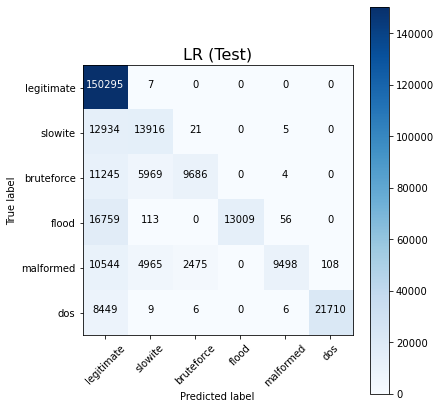

In [43]:
plt.figure(figsize=(6,6))
plot_confusion_matrix(lr_cv_result1, classes=target_names, title='LR (Test)')
plt.show()

Confusion matrix, without normalization


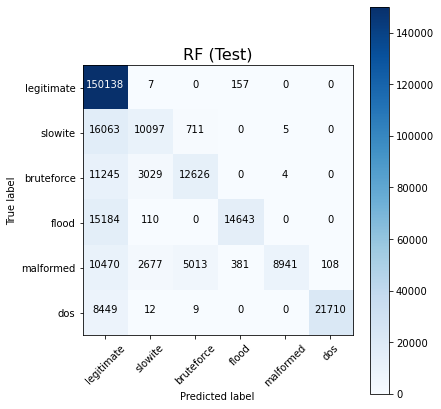

In [44]:
plt.figure(figsize=(6,6))
plot_confusion_matrix(rf_cv_result1, classes=target_names, title='RF (Test)')
plt.show()

---

# Tensorflow ML Models

#### Data preparation for tensorflow input

In [46]:
import tensorflow as tf
from tensorflow import keras 
import datetime

# train,validate,test
df_train = df0_pl
df_val, df_test = df1_pl.randomSplit([0.5,0.5])


# pandas
to_array = udf(lambda v: v.toArray().tolist(), ArrayType(FloatType()))
df_train_pandas = df_train.withColumn('features', to_array('features')).toPandas()
df_val_pandas = df_val.withColumn('features', to_array('features')).toPandas()
df_test_pandas = df_test.withColumn('features', to_array('features')).toPandas()


# tensors
x_train = tf.constant(np.array(df_train_pandas['features'].values.tolist()))
y_train = tf.constant(np.array(df_train_pandas['encoded_target'].values.tolist()))

x_validate = tf.constant(np.array(df_val_pandas['features'].values.tolist()))
y_validate = tf.constant(np.array(df_val_pandas['encoded_target'].values.tolist()))

x_test = tf.constant(np.array(df_test_pandas['features'].values.tolist()))
y_test = tf.constant(np.array(df_test_pandas['encoded_target'].values.tolist()))


# confirm gpu
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [47]:
# data shapes
print ("Train shape: ", x_train.shape, y_train.shape)
print ("Validation shape: ", x_validate.shape, y_validate.shape)
print ("Test shape: ", x_test.shape, y_test.shape)

Train shape:  (680316, 39) (680316,)
Validation shape:  (146075, 39) (146075,)
Test shape:  (145714, 39) (145714,)


In [48]:
def kfold(x, y, k):
    data_cv = tf.concat([x, tf.expand_dims(y,1)],axis = 1)
    data_cv = tf.random.shuffle(data_cv)
    N_samples = x.shape[0]
    N_subset = N_samples //k
    return_subsets = []

    for i in range(k):
        validation_i = tf.identity(data_cv[i*N_subset:(i+1)*N_subset,:])
        train_i_index = []
        if i > 0:
            train_i_index = train_i_index + list(range(0,i*N_subset))
        if i < k-1:
            train_i_index = train_i_index + list(range((i+1)*N_subset,N_samples))
        train_i = tf.identity(tf.gather(data_cv,train_i_index,axis = 0 ))

        return_subsets.append( (train_i[:,:-1],train_i[:,-1],validation_i[:,:-1],validation_i[:,-1]) )
    return return_subsets

### shuffled k fold sets   
x_cv = tf.concat([x_train,x_validate], axis=0)
y_cv = tf.concat([y_train,y_validate], axis=0)
ksets = kfold (x_cv, y_cv, 5)

### Model 1


**Hyperparameters:**
- Neural network depth (number of hidden layers)
- width(number of neurons per layer)
- optimizer 

In [52]:
def compile_model (hparams):
    k = len(ksets)
    
    for i in range(k):
        model = keras.Sequential()
        
        for _ in range(hparams[HP_DEPTH]):
            model.add(keras.layers.Dense(hparams[HP_WIDTH],activation='relu'))
        
        model.add(keras.layers.Dense(6))
    
    model.compile(
        optimizer = hparams[HP_OPTIMIZER],
        loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="Accuracy_epochs")])
    return model



def cv(model, hparams, ksets):
    k = len(ksets)
    accuracy = 0.0
    
    for sets in ksets:

        history = model.fit(sets[0], sets[1], epochs=5, verbose = 2,
                            validation_data = (sets[2], sets[3]),
                            callbacks=model_callbacks)

    accuracy += np.max (history.history["val_Accuracy_epochs"])
    return accuracy/k


In [55]:
from tensorboard.plugins.hparams import api as hp

# hyperparams
HP_WIDTH = hp.HParam('NN_width', hp.Discrete([20,30]))
HP_DEPTH = hp.HParam('NN_depth', hp.Discrete([1,2]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete (['adam','sgd']))


# callback / path
checkpoint_path = "mqtt_NN/model1/cv_model.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                         verbose=0,
                                                         save_best_only=True)

model_callbacks = [checkpoint_callback]

with tf.summary.create_file_writer("mqtt_NN/model1/hp_tuning").as_default():
    hp.hparams_config(
        hparams=[HP_WIDTH, HP_DEPTH, HP_OPTIMIZER],
        metrics=[hp.Metric('Accuracy')]
        )


In [56]:
# train loop
N = 0
logdir = "mqtt_NN/model1/hp_tuning/"
accuracies=[]
current_best_accuracy=0.0

for width in HP_WIDTH.domain.values:
    for depth in HP_DEPTH.domain.values:
        for optim in HP_OPTIMIZER.domain.values:

            hparams = {
                HP_WIDTH: width,
                HP_DEPTH: depth,
                HP_OPTIMIZER: optim
                }

            run_name = f"-WIDTH{int(hparams[HP_WIDTH])}-DEPTH{hparams[HP_DEPTH]}-{hparams[HP_OPTIMIZER]}"
            run_dir = logdir + run_name
            
            print(f'--- Trial {N+1}: {run_name}')
            print({h.name: hparams[h] for h in hparams})
        
            model = compile_model (hparams)
            accuracy = cv(model, hparams, ksets)
            accuracies.append (accuracy)
            
            
            # Best model save
            if accuracies[-1] > current_best_accuracy:
                print("Best model updated...")
                best_model1 = model
                current_best_accuracy = accuracies[-1]
                
            with tf.summary.create_file_writer(run_dir).as_default():
                hp.hparams(hparams)
                tf.summary.scalar("Accuracy", accuracy, step=1)
            
            N += 1

best_model1.save ("best_model1.h5")

--- Trial 1: -WIDTH20-DEPTH1-adam
{'NN_width': 20, 'NN_depth': 1, 'optimizer': 'adam'}
Epoch 1/5
INFO:tensorflow:Assets written to: mqtt_NN/model1\cv_model.ckpt\assets
20660/20660 - 14s - loss: 0.7094 - Accuracy_epochs: 0.7496 - val_loss: 0.6926 - val_Accuracy_epochs: 0.7546 - 14s/epoch - 672us/step
Epoch 2/5
INFO:tensorflow:Assets written to: mqtt_NN/model1\cv_model.ckpt\assets
20660/20660 - 13s - loss: 0.6915 - Accuracy_epochs: 0.7540 - val_loss: 0.6886 - val_Accuracy_epochs: 0.7549 - 13s/epoch - 641us/step
Epoch 3/5
INFO:tensorflow:Assets written to: mqtt_NN/model1\cv_model.ckpt\assets
20660/20660 - 13s - loss: 0.6889 - Accuracy_epochs: 0.7546 - val_loss: 0.6870 - val_Accuracy_epochs: 0.7552 - 13s/epoch - 640us/step
Epoch 4/5
INFO:tensorflow:Assets written to: mqtt_NN/model1\cv_model.ckpt\assets
20660/20660 - 13s - loss: 0.6876 - Accuracy_epochs: 0.7546 - val_loss: 0.6864 - val_Accuracy_epochs: 0.7551 - 13s/epoch - 643us/step
Epoch 5/5
INFO:tensorflow:Assets written to: mqtt_NN/mode

Epoch 5/5
20660/20660 - 12s - loss: 0.6917 - Accuracy_epochs: 0.7540 - val_loss: 0.6975 - val_Accuracy_epochs: 0.7521 - 12s/epoch - 576us/step
--- Trial 3: -WIDTH20-DEPTH2-adam
{'NN_width': 20, 'NN_depth': 2, 'optimizer': 'adam'}
Epoch 1/5
20660/20660 - 13s - loss: 0.7057 - Accuracy_epochs: 0.7507 - val_loss: 0.6922 - val_Accuracy_epochs: 0.7544 - 13s/epoch - 653us/step
Epoch 2/5
20660/20660 - 13s - loss: 0.6895 - Accuracy_epochs: 0.7540 - val_loss: 0.6843 - val_Accuracy_epochs: 0.7551 - 13s/epoch - 650us/step
Epoch 3/5
20660/20660 - 13s - loss: 0.6864 - Accuracy_epochs: 0.7545 - val_loss: 0.6825 - val_Accuracy_epochs: 0.7552 - 13s/epoch - 646us/step
Epoch 4/5
20660/20660 - 13s - loss: 0.6840 - Accuracy_epochs: 0.7547 - val_loss: 0.6806 - val_Accuracy_epochs: 0.7553 - 13s/epoch - 648us/step
Epoch 5/5
20660/20660 - 13s - loss: 0.6826 - Accuracy_epochs: 0.7547 - val_loss: 0.6793 - val_Accuracy_epochs: 0.7552 - 13s/epoch - 643us/step
Epoch 1/5
20660/20660 - 14s - loss: 0.6804 - Accuracy_e

Epoch 4/5
20660/20660 - 13s - loss: 0.6867 - Accuracy_epochs: 0.7543 - val_loss: 0.6843 - val_Accuracy_epochs: 0.7552 - 13s/epoch - 629us/step
Epoch 5/5
20660/20660 - 13s - loss: 0.6855 - Accuracy_epochs: 0.7546 - val_loss: 0.6828 - val_Accuracy_epochs: 0.7548 - 13s/epoch - 622us/step
Epoch 1/5
20660/20660 - 13s - loss: 0.6835 - Accuracy_epochs: 0.7551 - val_loss: 0.6869 - val_Accuracy_epochs: 0.7541 - 13s/epoch - 630us/step
Epoch 2/5
20660/20660 - 13s - loss: 0.6824 - Accuracy_epochs: 0.7554 - val_loss: 0.6858 - val_Accuracy_epochs: 0.7537 - 13s/epoch - 631us/step
Epoch 3/5
20660/20660 - 13s - loss: 0.6813 - Accuracy_epochs: 0.7555 - val_loss: 0.6834 - val_Accuracy_epochs: 0.7540 - 13s/epoch - 637us/step
Epoch 4/5
20660/20660 - 13s - loss: 0.6801 - Accuracy_epochs: 0.7557 - val_loss: 0.6850 - val_Accuracy_epochs: 0.7544 - 13s/epoch - 626us/step
Epoch 5/5
20660/20660 - 13s - loss: 0.6786 - Accuracy_epochs: 0.7560 - val_loss: 0.6979 - val_Accuracy_epochs: 0.7546 - 13s/epoch - 637us/step

Epoch 5/5
20660/20660 - 14s - loss: 0.6655 - Accuracy_epochs: 0.7639 - val_loss: 0.6610 - val_Accuracy_epochs: 0.7635 - 14s/epoch - 659us/step
Epoch 1/5
INFO:tensorflow:Assets written to: mqtt_NN/model1\cv_model.ckpt\assets
20660/20660 - 14s - loss: 0.6603 - Accuracy_epochs: 0.7664 - val_loss: 0.6532 - val_Accuracy_epochs: 0.7682 - 14s/epoch - 676us/step
Epoch 2/5
INFO:tensorflow:Assets written to: mqtt_NN/model1\cv_model.ckpt\assets
20660/20660 - 14s - loss: 0.6555 - Accuracy_epochs: 0.7683 - val_loss: 0.6445 - val_Accuracy_epochs: 0.7748 - 14s/epoch - 674us/step
Epoch 3/5
20660/20660 - 14s - loss: 0.6522 - Accuracy_epochs: 0.7694 - val_loss: 0.6553 - val_Accuracy_epochs: 0.7728 - 14s/epoch - 666us/step
Epoch 4/5
20660/20660 - 14s - loss: 0.6497 - Accuracy_epochs: 0.7700 - val_loss: 0.6933 - val_Accuracy_epochs: 0.7619 - 14s/epoch - 667us/step
Epoch 5/5
20660/20660 - 14s - loss: 0.6496 - Accuracy_epochs: 0.7701 - val_loss: 0.6510 - val_Accuracy_epochs: 0.7748 - 14s/epoch - 663us/step


In [58]:
test_loss, test_acc = best_model1.evaluate (x_test, y_test, verbose=2)

print ("\n- Best Model 1")
best_model1.summary()
print (f'Test loss: {test_loss:1.4f}')
print (f"Test accuracy: {test_acc*100:1.4f} %")


4554/4554 - 2s - loss: 0.6420 - Accuracy_epochs: 0.7738 - 2s/epoch - 468us/step

- Model 1
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_92 (Dense)            (None, 30)                1200      
                                                                 
 dense_93 (Dense)            (None, 30)                930       
                                                                 
 dense_94 (Dense)            (None, 6)                 186       
                                                                 
Total params: 2,316
Trainable params: 2,316
Non-trainable params: 0
_________________________________________________________________
Test loss: 0.6420
Test accuracy: 77.3776 %


---

### Model 2

Fixed Layers: [39, 60, 60, 6]
- 39 input nodes, 6 output nodes, two hidden layers with 60 nodes each

\
**Hyperparameters:**
- Activation function
- Learning rate

In [59]:
HP_actf = hp.HParam ('activation', hp.Discrete (['relu','sigmoid']))#, 'tanh']))
HP_lr = hp.HParam ('learning_rate', hp.Discrete([0.01])) #, 0.1, 1.0)))

# callback / path
checkpoint_path = "mqtt_NN/model2/cv_model.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                         verbose=0,
                                                         save_best_only=True)

model_callbacks = [checkpoint_callback]

def compile_model2 (hparams):

    input_dim = x_train.shape[1]
    output_dim = tf.unique (y_train)[0].shape[0]


    model2 = keras.Sequential( [keras.layers.Dense (input_dim, activation=hparams[HP_actf]),
                                keras.layers.Dense(60, activation=hparams[HP_actf]),
                                keras.layers.Dense(60, activation=hparams[HP_actf]),
                                keras.layers.Dense(output_dim)] )
    
    optimizer = keras.optimizers.SGD (learning_rate = hparams[HP_lr])
    
    model2.compile(optimizer = optimizer,
                   loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=[keras.metrics.SparseCategoricalAccuracy(name="Accuracy_epochs")])

    return model2

def cv(model, hparams, ksets):
    k = len(ksets)
    accuracy = 0.0
    
    for sets in ksets:

        history = model.fit(sets[0], sets[1], epochs=5, verbose = 2,
                            validation_data = (sets[2], sets[3]),
                            callbacks=model_callbacks)

    accuracy += np.max (history.history["val_Accuracy_epochs"])
    return accuracy/k

In [60]:
# train loop
N = 0
logdir = "mqtt_NN/model2/hp_tuning/"
accuracies=[]
current_best_accuracy=0.0

for actf in HP_actf.domain.values:
    for lr in HP_lr.domain.values:

        hparams = {
            HP_actf: actf,
            HP_lr: lr
        }

        run_name = "Model2 HP tuning"
        run_dir = logdir + run_name

        print(f'--- Trial {N+1}: {run_name}')
        print({h.name: hparams[h] for h in hparams})

        model2 = compile_model2 (hparams)
        accuracy = cv(model2, hparams, ksets)
        accuracies.append (accuracy)
        
        
        if accuracies[-1] > current_best_accuracy:
            print("Best model updated...")
            best_model2 = model2
            
            current_best_accuracy = accuracies[-1]
        
        
        with tf.summary.create_file_writer(run_dir).as_default():
            hp.hparams(hparams)
            tf.summary.scalar("Accuracy", accuracy, step=1)

        N += 1

best_model2.save ("best_model2.h5")

--- Trial 1: Model2 HP tuning
{'activation': 'relu', 'learning_rate': 0.01}
Epoch 1/5
INFO:tensorflow:Assets written to: mqtt_NN/model2\cv_model.ckpt\assets
20660/20660 - 16s - loss: 0.7224 - Accuracy_epochs: 0.7476 - val_loss: 0.7030 - val_Accuracy_epochs: 0.7526 - 16s/epoch - 787us/step
Epoch 2/5
INFO:tensorflow:Assets written to: mqtt_NN/model2\cv_model.ckpt\assets
20660/20660 - 15s - loss: 0.7007 - Accuracy_epochs: 0.7514 - val_loss: 0.6976 - val_Accuracy_epochs: 0.7529 - 15s/epoch - 721us/step
Epoch 3/5
20660/20660 - 14s - loss: 0.6976 - Accuracy_epochs: 0.7521 - val_loss: 0.6980 - val_Accuracy_epochs: 0.7472 - 14s/epoch - 694us/step
Epoch 4/5
INFO:tensorflow:Assets written to: mqtt_NN/model2\cv_model.ckpt\assets
20660/20660 - 15s - loss: 0.6956 - Accuracy_epochs: 0.7530 - val_loss: 0.6929 - val_Accuracy_epochs: 0.7511 - 15s/epoch - 711us/step
Epoch 5/5
20660/20660 - 14s - loss: 0.6943 - Accuracy_epochs: 0.7533 - val_loss: 0.6936 - val_Accuracy_epochs: 0.7544 - 14s/epoch - 693us/s

In [63]:
test_loss2, test_acc2 = best_model2.evaluate(x_test,y_test,verbose=1)

print ("\n- Model 2")
best_model2.summary()
print (f'Test loss: {test_loss2:1.4f}')
print (f"Test accuracy: {test_acc2*100:1.4f} %")


4554/4554 [==============================] - 3s 567us/step - loss: 0.6856 - Accuracy_epochs: 0.7552

- Model 2
Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_110 (Dense)           (None, 39)                1560      
                                                                 
 dense_111 (Dense)           (None, 60)                2400      
                                                                 
 dense_112 (Dense)           (None, 60)                3660      
                                                                 
 dense_113 (Dense)           (None, 6)                 366       
                                                                 
Total params: 7,986
Trainable params: 7,986
Non-trainable params: 0
_________________________________________________________________
Test loss: 0.6856
Test accuracy: 75.5247 %


---
---

### Loading Best Models

In [62]:
cv_model1 = keras.models.load_model ('best_model1.h5')
cv_model2 = keras.models.load_model ('best_model2.h5')

loss1, acc1 = cv_model1.evaluate (x_test, y_test)
loss2, acc2 = cv_model2.evaluate (x_test, y_test)

print (f"Model1 accuracy: {acc1*100:1.4f} %")
print (f"Model2 accuracy: {acc2*100:1.4f} %")

4554/4554 [==============================] - 3s 539us/step - loss: 0.6856 - Accuracy_epochs: 0.7552
Model1 accuracy: 77.3776 %
Model2 accuracy: 75.5247 %


#### best_model1 specs

In [109]:
# width, depth, optimizer
optim_config = cv_model1.optimizer.get_config()


cv_model1.summary()
print (f"CV Model 1 Optimizer: {optim_config['name']}")

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_92 (Dense)            (None, 30)                1200      
                                                                 
 dense_93 (Dense)            (None, 30)                930       
                                                                 
 dense_94 (Dense)            (None, 6)                 186       
                                                                 
Total params: 2,316
Trainable params: 2,316
Non-trainable params: 0
_________________________________________________________________
CV Model 1 Optimizer: Adam


#### best_model2 specs

In [101]:
# activation func
for i, layer in enumerate (cv_model2.layers):
    print ("- Layer", i)
    try:
        print ("    ",layer.activation)
    except AttributeError:
        print('   no activation attribute')


- Layer 0
     <function relu at 0x000001F1CC04A1F0>
- Layer 1
     <function relu at 0x000001F1CC04A1F0>
- Layer 2
     <function relu at 0x000001F1CC04A1F0>
- Layer 3
     <function linear at 0x000001F1CC04AC10>


In [107]:
# lr
best_lr = cv_model2.optimizer.learning_rate.numpy()

print (f"CV Model2 Learning rate: {best_lr:1.2f}")

CV Model2 Learning rate: 0.01


In [103]:
cv_model2.summary()

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_110 (Dense)           (None, 39)                1560      
                                                                 
 dense_111 (Dense)           (None, 60)                2400      
                                                                 
 dense_112 (Dense)           (None, 60)                3660      
                                                                 
 dense_113 (Dense)           (None, 6)                 366       
                                                                 
Total params: 7,986
Trainable params: 7,986
Non-trainable params: 0
_________________________________________________________________
